In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import os
from os import getcwd
from os import listdir
from os import mkdir
from os.path import isfile, join, isdir

import skimage
from skimage import measure
from skimage import io

from PIL import Image


from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Dense, Activation
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import backend as K


import tensorflow as tf
import tflearn
from tflearn.data_utils import shuffle
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from tflearn.metrics import Accuracy


Using TensorFlow backend.


In [2]:
def get_paths(foldNames):
  
    paths = dict.fromkeys(foldNames)

    for idx,g in enumerate(foldNames):
        fileNames = [f for f in listdir(join(trainPath,g)) if isfile(join(trainPath,g, f))]
        for i,f in enumerate(fileNames):
            fileNames[i] = join(trainPath,g,f)     
        paths[g] = fileNames
        
    return paths

def read_image(src):
    """Read and resize individual images"""
    im = io.imread(src)
    im = resize(im, (ROWS, COLS))
    return im


# Setup

In [3]:
ROWS = 90  #90 720
COLS = 160 #160 1280
CHANNELS = 3
trainPath = '../train'
testPath = '../test_stg1'
fish_classes = [f for f in listdir(trainPath) if isdir(join(trainPath, f))]
groupData = pd.DataFrame ({'group': fish_classes})
fish_paths = get_paths(fish_classes)

# Build x and y arrays

In [4]:
for idx,fish in enumerate(fish_classes):
    groupData.ix[idx,'num files'] = int(len(fish_paths[fish]))
    
files = []
Y_cat = []

for fish in fish_classes:
    fish_files = fish_paths[fish]
    files.extend(fish_files)
    
    y_fish = np.tile(fish, len(fish_files))
    Y_cat.extend(y_fish)
  
Y_cat = np.array(Y_cat) 


In [5]:
X_all = np.ndarray((len(files), ROWS, COLS, CHANNELS), dtype=np.uint8)

for i, f in enumerate(files): 
    im = read_image(f)
    X_all[i] = im
    if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))


Processed 0 of 3777
Processed 1000 of 3777
Processed 2000 of 3777
Processed 3000 of 3777


# view resampled image

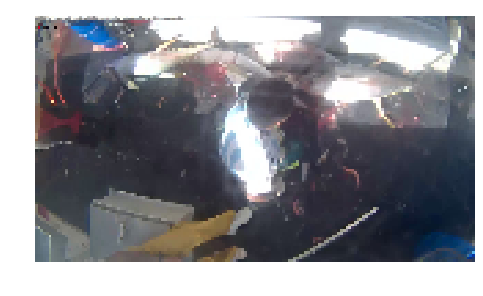

In [6]:
image = X_all[0]
plt.figure(figsize=(5, 5))
plt.imshow(im, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.tight_layout()
plt.show()

# Training data
* One hot encoding labels
* Split data


In [7]:
# One Hot Encoding Labels
#    Transform the categorical array Y_all into matrix of the same height, 
#    but with a boolean column for each category.
Y_all = LabelEncoder().fit_transform(Y_cat)
Y_all = np_utils.to_categorical(Y_all)

# test_size: between 0 and 1. proportion of the dataset to include in the test split
# random_state: Pseudo-random number generator state used for random sampling. How to shoose this?
# stratify: this is ensuring that the split datasets are balanced, i.e. contains the same 
# percentage of classes

X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, 
                                                    test_size=0.2, random_state=23, 
                                                    stratify=Y_all)

In [8]:
# read in test photo set
test_files = [im for im in os.listdir(testPath)]
test = np.ndarray((len(test_files), ROWS, COLS, CHANNELS), dtype=np.uint8)

for i, im in enumerate(test_files): 
    test[i] = read_image(join(testPath,im))
    

# Keras model
using this example:
https://www.kaggle.com/jeffd23/the-nature-conservancy-fisheries-monitoring/deep-learning-in-the-deep-blue-lb-1-279

In [9]:
optimizer = RMSprop(lr=1e-4)
objective = 'categorical_crossentropy'

def center_normalize(x):
    return (x - K.mean(x)) / K.std(x)


model = Sequential()
model.add(Activation(activation=center_normalize, input_shape=(ROWS, COLS, CHANNELS)))

model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(len(fish_classes)))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer)

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')        
        
model.fit(X_train, Y_train, batch_size=64, nb_epoch=1,
              validation_split=0.2, verbose=1, shuffle=True, callbacks=[early_stopping])

Train on 2416 samples, validate on 605 samples
Epoch 1/1
2416/2416 [==============================] - 519s - loss: 1.7924 - val_loss: 1.6022


In [11]:
preds = model.predict(X_valid, verbose=1)
print("Validation Log Loss: {}".format(log_loss(Y_valid, preds)))

756/756 [==============================] - 52s    
Validation Log Loss: 1.57353589246


In [12]:

#model predict
test_preds = model.predict(test, verbose=1)

1000/1000 [==============================] - 72s    


In [13]:
submission = pd.DataFrame(test_preds, columns=fish_classes)
submission.insert(0, 'image', test_files)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.897914,0.250127,0.127219,0.159282,0.392739,0.261198,0.226824,0.614217
1,img_00007.jpg,0.981027,0.166067,0.028061,0.064275,0.291034,0.132472,0.079484,0.449471
2,img_00009.jpg,0.887620,0.298751,0.126658,0.175105,0.392351,0.269902,0.218519,0.540020
3,img_00018.jpg,0.976592,0.174725,0.030280,0.068536,0.280680,0.163394,0.089208,0.426244
4,img_00027.jpg,0.944871,0.186667,0.066543,0.088767,0.344997,0.207171,0.197297,0.697494


# TFLEARN

In [29]:
def dnn_test1():
    #needed to run this tensorflow operation in order to build the network and subsequently 
    #create the model, multiple times. Rebuilding without resetting the tf.Graph object produces
    #errors. Could also get around this issue by restarting kernel, but that's annoying.
    
    #python with statement: it will use this session for the code following the with statement 
    # and then automatically close the session
    with tf.Graph().as_default():
#         n_nodes_hl1 = 500
#         n_nodes_hl2 = 500
#         n_nodes_hl3 = 500
#         n_classes = 10
#         batch_size = 100
    
        # normalisation of images
        img_prep = ImagePreprocessing()
        img_prep.add_featurewise_zero_center()
        img_prep.add_featurewise_stdnorm()

        # Create extra synthetic training data by flipping & rotating images
        img_aug = ImageAugmentation()
        img_aug.add_random_flip_leftright()
        img_aug.add_random_rotation(max_angle=25.)

        
        #specific a specific device or gpu
#           with tf.device("/gpu:1"): 
        
        #input layer with shape of data specified. In this case, dimensions of our images, 
        #rows X cols X rgb array. The initial 'None' is for an unknown dimension reflecting the 
        #"number of samples that are processed in a batch"
        network = input_data(shape=[None, ROWS, COLS, 3],
                        data_preprocessing=img_prep,
                        data_augmentation=img_aug)
        
        # 1: Convolution layer with 32 filters, each 3x3x3
        conv_1 = conv_2d(network, 32, 3, activation='relu', name='conv_1')

        # 2: Max pooling layer
        network = max_pool_2d(conv_1, 2)

        # 3: Convolution layer with 64 filters
        conv_2 = conv_2d(network, 64, 3, activation='relu', name='conv_2')

        # 4: Convolution layer with 64 filters
        conv_3 = conv_2d(conv_2, 64, 3, activation='relu', name='conv_3')

        # 5: Max pooling layer
        network = max_pool_2d(conv_3, 2)

        # 6: Fully-connected 512 node layer
        network = fully_connected(network, 512, activation='relu')

        # 7: Dropout layer to combat overfitting
        network = dropout(network, 0.5)

        #output latyer
        network = fully_connected(network, 8, activation='softmax')
        
        # Configure how the network will be trained
        acc = Accuracy(name="Accuracy")
        
        network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.0005, metric=acc)
        return tflearn.DNN(network)


In [ ]:
def dnn_test2():
    #needed to run this tensorflow operation in order to build the network and subsequently 
    #create the model, multiple times. Rebuilding without resetting the tf.Graph object produces
    #errors. Could also get around this issue by restarting kernel, but that's annoying.
    
    #python with statement: it will use this session for the code following the with statement 
    # and then automatically close the session
    with tf.Graph().as_default():
#         n_nodes_hl1 = 500
#         n_nodes_hl2 = 500
#         n_nodes_hl3 = 500
#         n_classes = 10
#         batch_size = 100
    
        # normalisation of images
        img_prep = ImagePreprocessing()
        img_prep.add_featurewise_zero_center()
        img_prep.add_featurewise_stdnorm()

        # Create extra synthetic training data by flipping & rotating images
        img_aug = ImageAugmentation()
        img_aug.add_random_flip_leftright()
        img_aug.add_random_rotation(max_angle=25.)

        
        #specific a specific device or gpu
#           with tf.device("/gpu:1"): 
        
        #input layer with shape of data specified. In this case, dimensions of our images, 
        #rows X cols X rgb array. The initial 'None' is for an unknown dimension reflecting the 
        #"number of samples that are processed in a batch"
        network = input_data(shape=[None, ROWS, COLS, 3],
                        data_preprocessing=img_prep,
                        data_augmentation=img_aug)
        
        # 1: Convolution layer with 32 filters, each 3x3x3
        conv_1 = conv_2d(network, 32, 3, activation='relu', name='conv_1')

        # 2: Max pooling layer
        network = max_pool_2d(conv_1, 2)
        

        # 3: Convolution layer with 64 filters
        conv_2 = conv_2d(network, 64, 3, activation='relu', name='conv_2')

        # 4: Convolution layer with 64 filters
        conv_3 = conv_2d(conv_2, 64, 3, activation='relu', name='conv_3')

        # 5: Max pooling layer
        network = max_pool_2d(conv_3, 2)

        # 6: Fully-connected 512 node layer
        network = fully_connected(network, 512, activation='relu')

        # 7: Dropout layer to combat overfitting
        network = dropout(network, 0.5)

        #output latyer
        network = fully_connected(network, 8, activation='softmax')
        
        # Configure how the network will be trained
        acc = Accuracy(name="Accuracy")
        
        network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.0005, metric=acc)
        return tflearn.DNN(network)


In [26]:
# Define model
model_tf = dnn_test1()

# Start training (apply gradient descent algorithm). Will want to specify multiple epochs 
# typically unless just testing
model_tf.fit(X_train, Y_train, n_epoch=1,validation_set=(X_valid,Y_valid),
          show_metric=True, batch_size=15)


Training Step: 201  | total loss: 0.53637 | time: 220.876s
| Adam | epoch: 001 | loss: 0.53637 - Accuracy: 0.8390 -- iter: 3015/3021
Training Step: 202  | total loss: 0.50344 | time: 241.079s
| Adam | epoch: 001 | loss: 0.50344 - Accuracy: 0.8485 | val_loss: 0.50991 - val_acc: 0.8360 -- iter: 3021/3021
--


In [28]:
# model.evaluate(X_valid,Y_valid)
preds = model_tf.predict(X_valid)
# print("Validation Log Loss: {}".format(log_loss(Y_valid, preds)))

TypeError: ufunc 'subtract' output (typecode 'O') could not be coerced to provided output parameter (typecode 'B') according to the casting rule ''same_kind''

In [25]:
#model predict
test_preds1 = model.predict(test)

submission = pd.DataFrame(test_preds1, columns=fish_classes)
submission.insert(0, 'image', test_files)

if not os.path.exists('../tflearn'):
    os.makedirs('../tflearn')

submission.to_csv('../tflearn/submission.csv',index = False)

print submission.head()

TypeError: ufunc 'subtract' output (typecode 'O') could not be coerced to provided output parameter (typecode 'B') according to the casting rule ''same_kind''

# Straight tensor flow

In [ ]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot = True)

# begin building that model

In [ ]:
n_nodes_hl1 = 500
n_nodes_hl2 = 500
n_nodes_hl3 = 500
n_classes = 10
batch_size = 100


In [ ]:
output = sess.run(result)
print(output)
